**RANDOM DROPOUT VISUALIZATION**

In [ ]:
import numpy as np
import torch
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pygmtools as pygm
pygm.set_backend('pytorch')
import json
import pickle 

from torch.utils.data import DataLoader

import wandb

from datasets.graph_matching_dataset import GraphMatchingDataset

from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.utils.data import Subset

from visualization_tools.vvg_loader import vvg_to_df
from spatial_vessel_matching import spatial_vessel_matching


import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.colors as mcolors
from PIL import Image
from skimage import morphology

import sys
parent_dir = os.path.abspath("../../")
sys.path.append(parent_dir)
from tools.get_coords_and_info import get_info_graph
from tools.calculate_metrics import calculate_metrics
from visualization_tools.vvg_colored_graph import colored_graph


def _load_data_graph(edges_file, json_dir):
        """Helper function to load graph data from CSV and JSON files."""
        data_edges_graph = pd.read_csv(edges_file, delimiter=';')
        json_edges, json_nodes = vvg_to_df(json_dir)
        return data_edges_graph, json_edges

def idxs_from_matrix(X):
    final_idxs = []
    for i in range(len(X)):
        point1 = i  # we are matching graph 1 to graph 2!!!
        point2 = torch.argmax(X[i]).item()
        final_idxs.append({'graph1': point1, 'graph2': point2})
    return final_idxs

def idxs_gt(X):
    final_idxs = {}
    for i in range(len(X)):
        point1 = i  # we are matching graph 1 to graph 2!!!
        point2 = torch.argmax(X[i]).item()
        if X[i,point2] == 1: # otherwise there is no match
            final_idxs[point1] = point2
    return final_idxs

import json

def filter_json_file(json_file, selected_indexes):
    # Load the JSON file
    with open(json_file, 'r') as f:
        json_data = json.load(f)
    
    # Initialize the filtered edges list and the mapping dictionary
    filtered_edges = []
    old_to_new_id_mapping = {}

    new_id = 0  # Start the new ID counter

    # Iterate over the edges in the JSON file
    for edge in json_data['graph']['edges']:
        # Check if the edge is not in the selected indexes (meaning it should be kept)
        if edge['id'] not in selected_indexes:
            # Map the old ID to the new ID
            old_to_new_id_mapping[edge['id']] = new_id
            # Update the edge's ID
            edge['id'] = new_id
            # Add the updated edge to the filtered edges list
            filtered_edges.append(edge)
            new_id += 1

    # Update the edges in the JSON data
    json_data['graph']['edges'] = filtered_edges

    return json_data, old_to_new_id_mapping


def labeled_cl_graph(base_img, graph_points, labels):
    labeled_centerline = np.zeros_like(base_img)
    dict_labels = {}

    for vessel in graph_points:
        vessel_coords = np.array(graph_points[vessel]['centerline'])
        vessel_coords = np.round(vessel_coords).astype(int)
        labeled_centerline[vessel_coords[:, 0], vessel_coords[:, 1]] = labels[vessel]
        dict_labels[vessel] = labels[vessel]

    return labeled_centerline, dict_labels

def labeled_cl_graph_modified(base_img, graph_points_modified, labels, original_graph_points):
    labeled_centerline = np.zeros_like(base_img)
    dict_labels = {}

    for vessel in graph_points_modified:
        vessel_coords = np.array(graph_points_modified[vessel]['centerline'])
        vessel_coords = np.round(vessel_coords).astype(int)
        labeled_centerline[vessel_coords[:, 0], vessel_coords[:, 1]] = labels[vessel]
        dict_labels[vessel] = labels[vessel]

    for vessel in original_graph_points:
        if vessel not in graph_points_modified:
            vessel_coords = np.array(original_graph_points[vessel]['centerline'])
            vessel_coords = np.round(vessel_coords).astype(int)
            if labeled_centerline[vessel_coords[:, 0], vessel_coords[:, 1]].all() != 0 and labeled_centerline[vessel_coords[:, 0], vessel_coords[:, 1]].any() == 0:
                print('Error')
                print(vessel)
            if labeled_centerline[vessel_coords[:, 0], vessel_coords[:, 1]].all() == 0:
                labeled_centerline[vessel_coords[:, 0], vessel_coords[:, 1]] = 10000
            dict_labels[vessel] = 10000
            
    return labeled_centerline, dict_labels

def labeled_cl_solution(base_img, graph_points, ground_truth, prediction):
    labeled_centerline = np.zeros(base_img.shape)
    dict_labels = {}

    for vessel in graph_points:
        vessel_coords = np.array(graph_points[vessel]['centerline'])
        vessel_coords = np.round(vessel_coords).astype(int)

        # Compare the prediction to ground truth
        # label 1 for true positive, 2 for false positive, 3 for false negative
        if vessel in ground_truth and vessel in prediction:
            if ground_truth[vessel] == prediction[vessel]:
                label = 1
            else:
                label = 2
        elif vessel in ground_truth and vessel not in prediction:
            label = 3
        else:
            label = 2

        labeled_centerline[vessel_coords[:, 0], vessel_coords[:, 1]] = label
        dict_labels[vessel] = label

    return labeled_centerline, dict_labels

def labeled_image(seg, cl):

    seg[seg != 0] = 1
    final_seg_label = np.zeros_like(seg, dtype=np.uint16)
    final_seg_label[(seg != 0) & (cl != 0)] = 1

    cl_vessel = cl.copy()

    label_cl = cl_vessel  # measure.label(cl_vessel)
    label_cl[label_cl != 0] = label_cl[label_cl != 0] + 1  # it was + 1
    final_seg_label[label_cl != 0] = label_cl[label_cl != 0]

    for i in range(100):
        label_cl = morphology.dilation(label_cl, morphology.square(3))

        label_cl = label_cl * seg

        # get the values of final_seg_label where no semantic segmentation is present
        final_seg_label[final_seg_label == 1] = label_cl[final_seg_label == 1]
        # get indices where label_cl==0 and seg !=0
        mask = (final_seg_label == 0) & (seg != 0)
        final_seg_label[mask] = 1

    # pixels that are still 1 are turned into 0
    final_seg_label[final_seg_label == 1] = 0
    # labels for the rest are corrected by -1
    final_seg_label[final_seg_label != 0] = (
        final_seg_label[final_seg_label != 0] - 1
    )

    return final_seg_label





valid_feats = ['length', 'distance', 'curveness', 'volume', 'avgCrossSection', 'minRadiusAvg', 'avgRadiusAvg', 'roundnessAvg']



In [ ]:
dataset_name = 'soul_dataset_big'
src_dir = f'../data/{dataset_name}/'
transforms_dir = os.path.join(src_dir, 'transformed_images')

# Initialize the dataset
dataset_our_algorithm = GraphMatchingDataset(src_dir=src_dir,  
                            transforms_dir=transforms_dir)

**RESULTS VISUALIZATION**

INDEX --> ('33_49',)
INDEX --> ('33_49',)
INDEX --> ('33_49',)
INDEX --> ('33_49',)


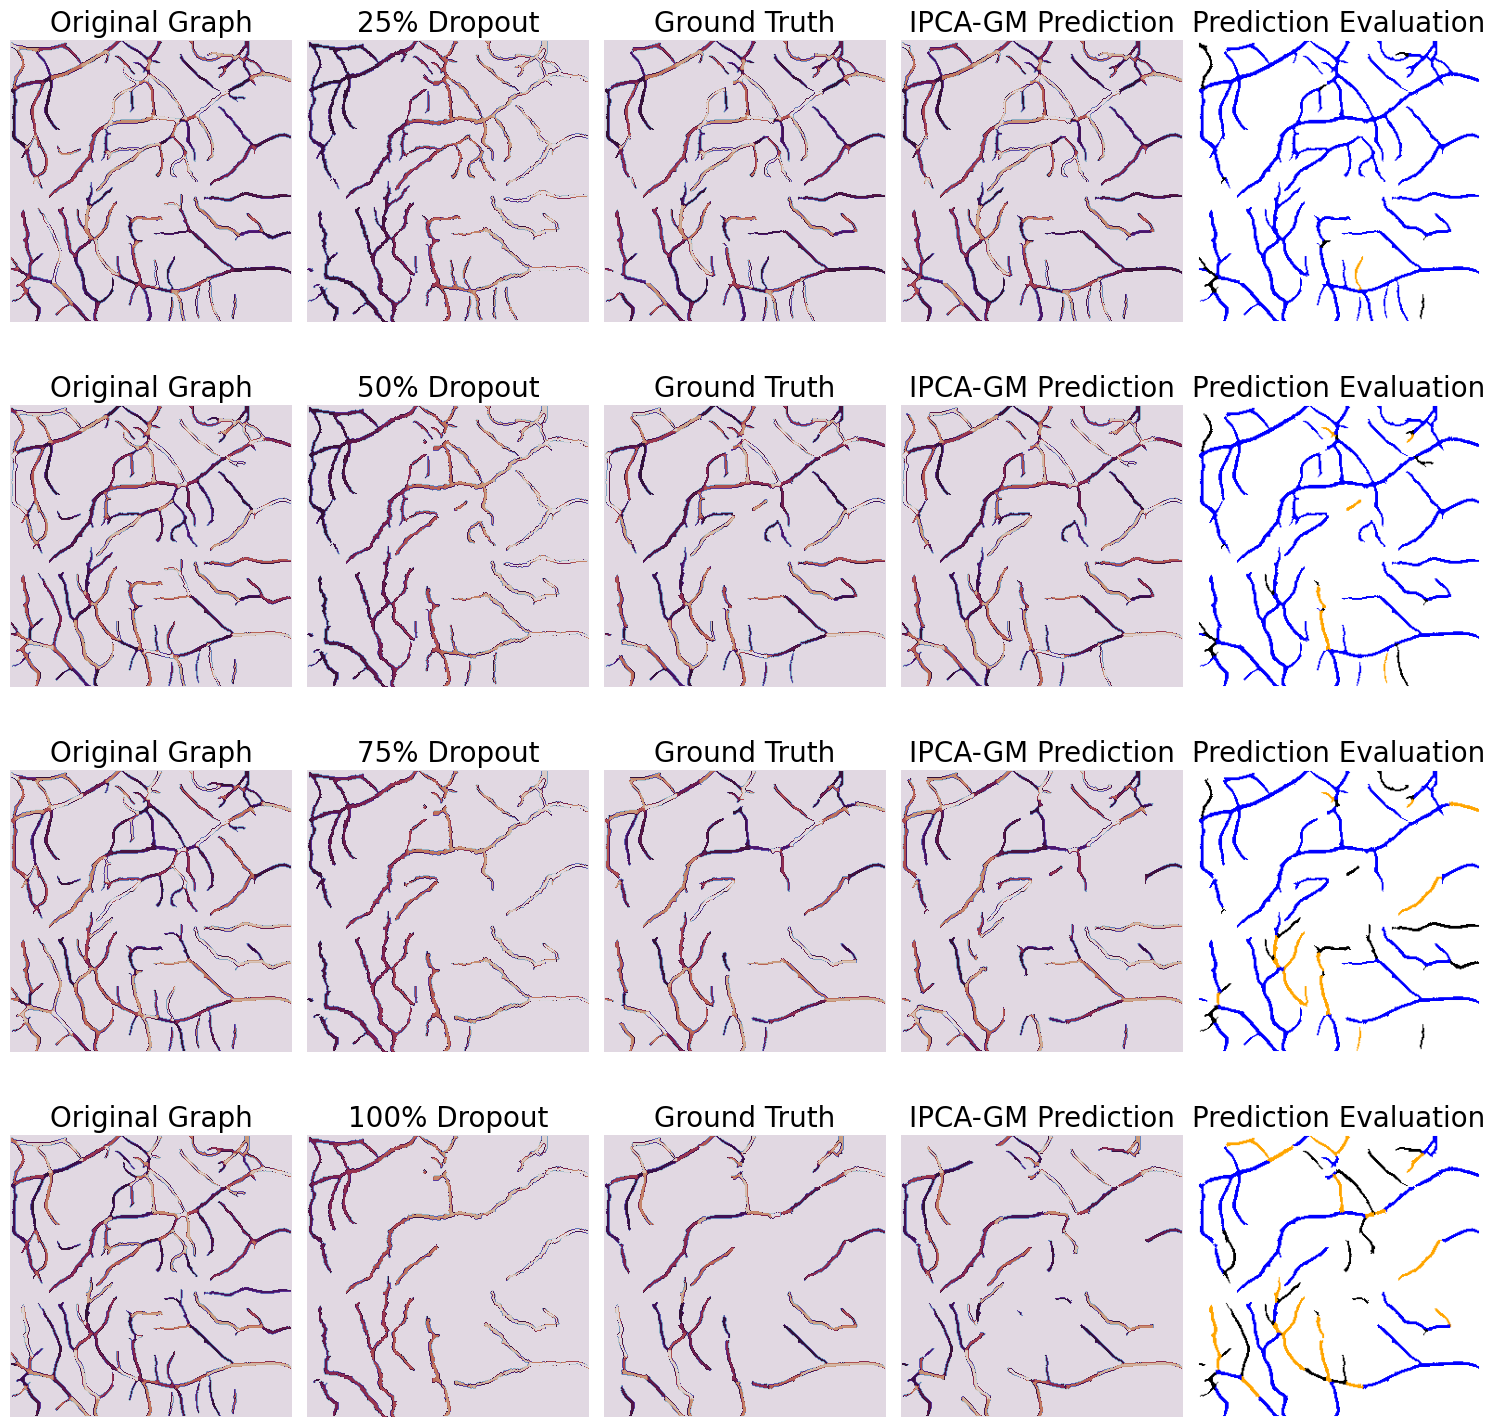

In [115]:
drop_values = [25,50,75,100]

# Create a figure with three subplots in a row (1 row, 3 columns)
fig, axes = plt.subplots(4, 5, figsize=(15, 15))

i = 0
for drop_value in drop_values:
    output_dir = f'../data/soul_random_drop_vessels/random_{drop_value}_drop/'

    dataset = dataset_our_algorithm

    test_idxs = []
    for file in os.listdir('GM_results/pygm_classic/ipfp_matrix_results/'):
        if file.endswith('.npy'):
            test_idxs.append(file.split('.')[0])

    test_set = Subset(dataset, [dataset.indexes.index(idx) for idx in test_idxs])

    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


    src_dir = '../data/soul_dataset_big'

    

    # Iterate over DataLoader
    for batch_idx, (index, gt) in enumerate(test_loader):

        if batch_idx == 0:
            print('INDEX -->', index)

            T_seg = index[0]
            seg = T_seg.split('_')[0]
            
            segmentation = np.array(Image.open(os.path.join(src_dir, 'segmentations', seg + '.png')))
            edges_file = os.path.join(src_dir, 'graph_extracted_full', seg + '_full_edges.csv')
            json_dir = os.path.join(src_dir, 'graph_extracted_full', seg + '_full_graph_filtered.json')
            data_edges_graph, json_edges = _load_data_graph(edges_file, json_dir)
            vessels_pts_graph, bif_pts_graph = get_info_graph(data_edges_graph, json_edges)
            color_graph = colored_graph(os.path.join(src_dir, 'segmentations', seg + '.png'), json_dir)
            labels_1 = np.arange(100, 100 + len(vessels_pts_graph))
            #np.random.seed(42)
            np.random.shuffle(labels_1)
            graph1_label_cl, graph1_to_labels1 = labeled_cl_graph(color_graph, vessels_pts_graph, labels_1)
            graph1_labeled_img = labeled_image(segmentation, graph1_label_cl)

            # Load the transformed img graph data
            segmentation_T_or = np.array(Image.open(os.path.join(src_dir, 'transformed_images', T_seg + '.png')))
            edges_file_T_or = os.path.join(src_dir, 'graph_extracted_full', T_seg + '_full_edges.csv')
            json_dir_T_or = os.path.join(src_dir, 'graph_extracted_full', T_seg + '_full_graph_filtered.json')
            data_edges_graph_T_or, json_edges_T_or = _load_data_graph(edges_file_T_or, json_dir_T_or)
            vessels_pts_graph_T_or, bif_pts_graph_T_or= get_info_graph(data_edges_graph_T_or, json_edges_T_or)
            color_graph_T_or = colored_graph(os.path.join(src_dir, 'transformed_images', T_seg + '.png'), json_dir_T_or)


            # Load the modified img graph data
            mod_dir = output_dir
            edges_file_T_mod = os.path.join(mod_dir, 'graph_extracted_full', T_seg + '_full_edges.csv')
            json_dir_T_mod = os.path.join(mod_dir, 'graph_extracted_full', T_seg + '_full_graph_filtered.json')
            data_edges_graph_T_mod, json_edges_T_mod = _load_data_graph(edges_file_T_mod, json_dir_T_mod)
            vessels_pts_graph_T_mod, bif_pts_graph_T_mod= get_info_graph(data_edges_graph_T_mod, json_edges_T_mod)

            labels_2_mod = np.arange(100, 100+len(vessels_pts_graph_T_mod))
            #np.random.seed(42)
            #np.random.shuffle(labels_2_mod)
            graph2_label_cl_mod, graph2_to_labels2_mod = labeled_cl_graph_modified(np.zeros((304,304),np.uint16), vessels_pts_graph_T_mod, labels_2_mod, vessels_pts_graph_T_or)

            with open(os.path.join(mod_dir,'old_to_new_map', T_seg + '.pkl'), 'rb') as file:
                old_to_new_id_mapping = pickle.load(file)

            graph2_labeled_img_mod = np.zeros_like(graph2_labeled_img) 
            for vessel1, vessel2 in old_to_new_id_mapping.items():
                label1 = graph2_to_labels2[vessel1]
                label2_mod = graph2_to_labels2_mod[vessel2]
                graph2_labeled_img_mod[graph2_labeled_img==label1] = label2_mod

            # Load ground truth
            gt = np.load(os.path.join(mod_dir, 'gt', T_seg + '.npy'))
            gt_1_to_mod = idxs_gt(torch.from_numpy(gt))
            gt_graph = np.zeros_like(graph2_labeled_img) 
            for vessel1, vessel2 in gt_1_to_mod.items():
                label1 = graph1_to_labels1[vessel1]
                gt_graph[graph1_labeled_img==label1] = label1



            
            axes[i,0].imshow(graph1_labeled_img, cmap='twilight')
            axes[i,0].set_title('Original Graph', fontsize=20)

            axes[i,1].imshow(graph2_labeled_img_mod, cmap='twilight')
            axes[i,1].set_title(f'{drop_value}% Dropout', fontsize=20)

            axes[i,2].imshow(gt_graph, cmap='twilight')
            axes[i,2].set_title(f'Ground Truth', fontsize=20)


            # Load the predicted matrix
            model = 'ipca_gm'
            pred_dir = os.path.join(f'GM_results_random_{drop_value}_drop', 'pygm_neural_old', f'{model}_matrix_results', T_seg + '.npy')
            pred = np.load(pred_dir)
            pred_1_to_2 = idxs_gt(torch.from_numpy(pred))

            # Create the predicted and solution images (solution images with true and false positives)
            pred_graph1 = np.zeros_like(graph1_labeled_img) 
            #sol_graph2 = np.zeros_like(graph2_labeled_img)
            sol_graph1 = np.ones((*graph2_labeled_img_mod.shape, 3), dtype=np.float32)

            vessels = []
            for vessel1, vessel2 in pred_1_to_2.items():
                label1 = graph1_to_labels1[vessel1]
                if vessel1 in gt_1_to_mod.keys() and gt_1_to_mod[vessel1] == vessel2:
                    sol_graph1[graph1_labeled_img==label1] = colors.to_rgb('blue') # True positive
                elif vessel1 in gt_1_to_mod.keys() and gt_1_to_mod[vessel1] != vessel2:
                    sol_graph1[graph1_labeled_img==label1] = colors.to_rgb('orange') # False positive
                elif vessel1 not in gt_1_to_mod.keys():
                    sol_graph1[graph1_labeled_img==label1] = colors.to_rgb('black')

                    
                pred_graph1[graph1_labeled_img==label1] = label1

            # Add False negatives
            for vessel1, vessel2 in gt_1_to_mod.items():
                if vessel1 not in pred_1_to_2.keys():
                    label1 = graph1_to_labels1[vessel1]
                    sol_graph1[graph1_labeled_img==label1] = colors.to_rgb('orange') # False negative

            axes[i,3].imshow(pred_graph1, cmap='twilight')
            axes[i,3].set_title(f'IPCA-GM Prediction', fontsize=20)

            axes[i,4].imshow(sol_graph1)
            axes[i,4].set_title(f'Prediction Evaluation', fontsize=20)


            i += 1
            break
            
for row in axes:
    for ax in row:
        ax.axis('off')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

    